In [24]:
from src.utils.data_utils import load_dataframe_from_csv
from src.data.dataloader import load_initial_dataset
from clean_cmu import clean_movies_cmu
from src.scripts.movie_analysis import clean_film_full, create_heatmap, create_pvalue_table, compute_pvalues, compute_countries_count, analyze_genres, year_formatting, run_time_analysis, sentiment_analysis

from config import *

import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# What makes a movie win an award?

With the subquestions stated in our README, this `results.ipynb` shows how we are able to have a quality dataset that will serve for our data analysis.

First, we fetch our Oscars award winning dataset of actors, and our dataset that is enriched.


In [44]:
movie = load_dataframe_from_csv('movie_cmu.csv')
character = load_dataframe_from_csv('character.csv')
plot_summaries = load_dataframe_from_csv('plot_summaries.csv')
tvtropes = load_dataframe_from_csv('tvtropes.csv')
name_clusters = load_dataframe_from_csv('name_clusters.csv')
oscar_winning_films = load_dataframe_from_csv('oscar_winning_films_ids.csv')
oscar_winning_actors = load_dataframe_from_csv('oscar_winning_actors.csv')
oscar_winning_actresses = load_dataframe_from_csv('oscar_winning_actresses.csv')
oscar_supporting_actors = load_dataframe_from_csv('oscar_winning_supporting_actors.csv')
oscar_supporting_actresses = load_dataframe_from_csv('oscar_winning_supporting_actresses.csv')
extended_films = load_dataframe_from_csv('film_2015_2024.csv')
academy_award_winning_films = load_dataframe_from_csv('acedemy_award_winning_films')
winning_actors_info = load_dataframe_from_csv('winning_actors_information.csv')
film_full =  load_dataframe_from_csv('film_full_2.csv')
imdb_ratings = load_dataframe_from_csv('imdb_ratings.csv')

<b/>First of all, let's analyze some basic statistics of our dataset, before doing a more complex analysis<b/>

In [3]:
#Convert the number of oscar received into integer values, when there are Nans we consider that the films didn"t received or where nominated for any oscars
film_full = clean_film_full(film_full)

Let's look at some repartition of our data for both films with oscars and film without as our analysis will be focusion on this duality

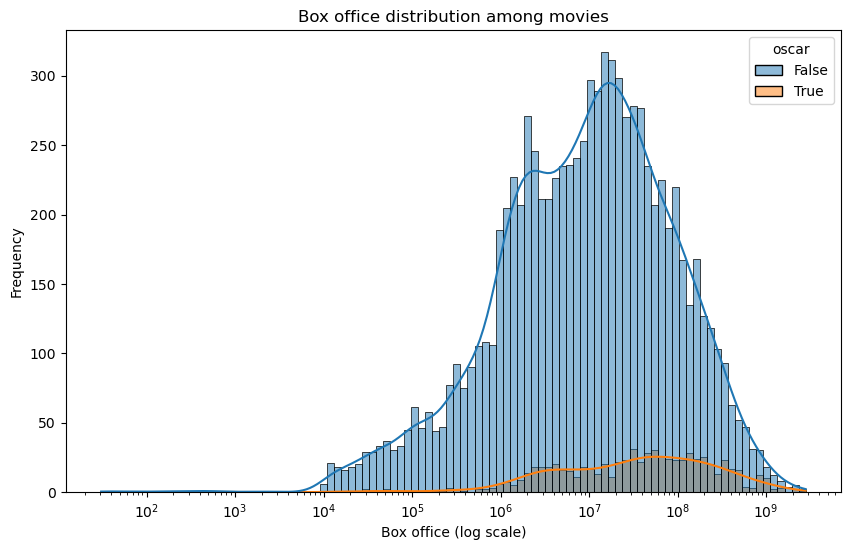

In [4]:
# Drop rows with NaN in the 'box_office' column
box_office_distribution = film_full.dropna(subset=['box_office'], inplace=False)

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(box_office_distribution ,  x='box_office',hue='oscar',bins=100, kde=True, log_scale=True)
plt.title('Box office distribution among movies')
plt.xlabel('Box office (log scale)')
plt.ylabel('Frequency')
plt.show()


We can see that the box office for film that won and din't win oscars follow a power law distribution as when applying the log scale it is normally distributed (although it is a skewed distribution with higher kurtosis than a gaussian).
The box office distribution is higher skewed towards the right, meaning that box office might be a determinant factor for oscar films, we will review this further in our analysis.

Run time analysis 

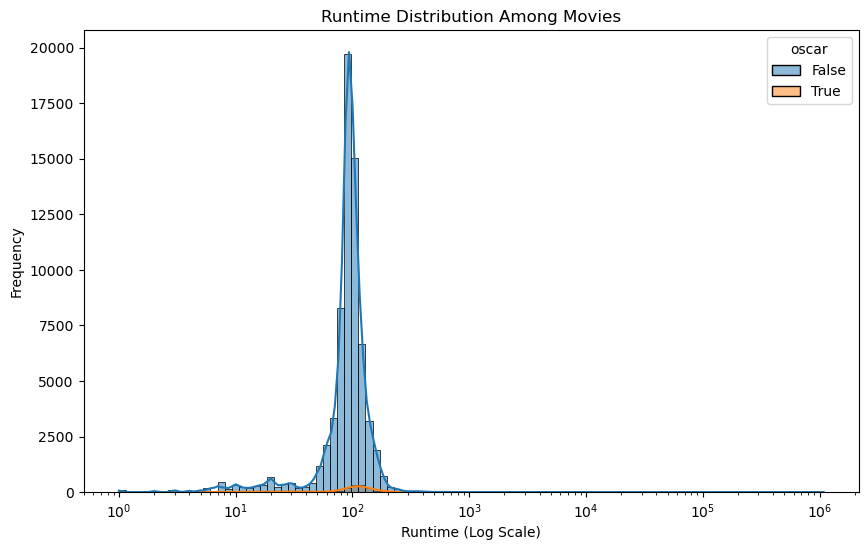

In [5]:
# Drop rows with NaN in the 'runtime' column
run_time_distribution = film_full.dropna(subset=['runtime'], inplace=False)

# Ensure 'runtime' has no inf or negative values 
run_time_distribution  = run_time_distribution [run_time_distribution ['runtime'] > 0]  # Log scale can't handle zero or negative values

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(run_time_distribution , x='runtime', hue='oscar', bins=100, kde=True, log_scale=True)
plt.title('Runtime Distribution Among Movies')
plt.xlabel('Runtime (Log Scale)')
plt.ylabel('Frequency')
plt.show()


There is a high concentration of films with about the same running time, this can be explained by the fact that films usually have around the same running time ????? TODO. 
We will confirm those results by looking at correlation between our variables, and p values.

In [6]:
from turtle import color


df_plot1 = film_full[['box_office', 'nbOscarReceived', 'title', 'release_date']]
df_plot1 = df_plot1[df_plot1['nbOscarReceived'] > 0].dropna()
df_plot1['release_date'] = df_plot1['release_date'].apply(lambda x: x.split("-")[0])


fig1 = px.scatter(
    df_plot1,
    x='box_office',
    y='nbOscarReceived',
    title='Box Office Revenue vs. Awards Received',
    labels={'box_office': 'Box Office Revenue', 'awardsReceived': 'Awards Received'},
    color = 'release_date',
    log_x=True,  # Use log scale for box office
    hover_data=['title']
)
fig1.show()

df_plot2 = film_full[['runtime', 'nbOscarReceived', 'title']]
df_plot2 = df_plot2[df_plot2['nbOscarReceived'] > 0].dropna()

fig2 = px.scatter(
    df_plot2,
    x='runtime',
    y='nbOscarReceived',
    title='Runtime vs. Awards Received',
    labels={'runtime': 'Runtime', 'awardsReceived': 'Awards Received'},
    hover_data=['title']
)

fig2.show()

df_plot3 = film_full[['reviewScores', 'nbOscarReceived', 'title']]
df_plot3 = df_plot3[df_plot3['nbOscarReceived'] > 0].dropna()

fig3 = px.scatter(
    df_plot3,
    x='reviewScores',
    y='nbOscarReceived',
    title='Review Scores vs. Awards Received',
    labels={'reviewScores': 'Review Scores', 'awardsReceived': 'Awards Received'},
    hover_data=['title']
)

fig3.show()

BLABLA,
let's look at the pearson or spearman correlation

In [7]:
# Continuous columns
continuous_cols = ['box_office', 'runtime', 'reviewScores', 'capitalCost', 'nbOscarReceived', 'nbOscarNominated']

# Compute correlation matrices
pearson_corr = film_full[continuous_cols].corr(method='pearson')
spearman_corr = film_full[continuous_cols].corr(method='spearman')

# Create heatmaps
create_heatmap(pearson_corr, "Pearson Correlation Heatmap")
create_heatmap(spearman_corr, "Spearman Correlation Heatmap")

BLABLABLA

In [8]:
r = film_full.dropna(subset=['reviewScores', 'box_office', 'runtime'], inplace=False)
continuous_cols = ['box_office', 'runtime', 'reviewScores']

oscar_winners = r[r['nbOscarReceived'] > 0]
non_oscar_winners = r[r['nbOscarReceived'] == 0]

p_values_dict = compute_pvalues(oscar_winners, non_oscar_winners, continuous_cols)
p_values_df = pd.DataFrame([p_values_dict], index=['p-value']).T
p_values_df['p-value'] = p_values_df['p-value'].apply(lambda x: f"{x:.2e}")

create_pvalue_table(p_values_df, "P-Values: Oscar Winners vs Non-Winners")


BLABLABLA

Now, let's dive further in the movie analysis, now that we have insights on how the variables of our dataset interact with each other

In [9]:
count = compute_countries_count(film_full)

fig = px.choropleth(
    count, 
    locations="iso_alpha", 
    color="nbOscarReceived",
    hover_name="countries",
    projection="natural earth", 
    title='Location where oscar winning films were shot',
    color_continuous_scale=px.colors.sequential.Sunsetdark

)
fig.update_geos(showcountries = True)

fig.show()


BLABLABLA

Now let's take a look at the genre repartition for the movies

In [10]:
genres_analyzed = analyze_genres(film_full)

genres_oscars_agg = genres_analyzed.groupby('categories').agg(oscar_count=('nbOscarReceived', 'sum')).reset_index()

fig = px.scatter(genres_oscars_agg, 
                 x="oscar_count", 
                 y='categories',
                 size="oscar_count", 
                 color="categories", 
                 hover_name="categories", 
                 log_x= True,
                 size_max=60,
                 title='Genre distribution among awarded films')
 
fig.update_layout(yaxis_visible=False, yaxis_showticklabels=False)
fig.show()


In [11]:

cat_awards = genres_analyzed.explode('categories').groupby('categories')['nbOscarReceived'].sum().reset_index().sort_values('nbOscarReceived', ascending=False)

fig = px.bar(cat_awards,
              x='categories', y='nbOscarReceived', title="Award Nominations by Genre")
fig.show()

genres_analyzed['release_month'] = genres_analyzed['release_date'].apply(lambda x: x.split("-")[1] if isinstance(x, str) else x)

fig = px.line(genres_analyzed.groupby('release_month')['nbOscarReceived'].sum().reset_index(),
              x='release_month', y='nbOscarReceived', 
              title="Award-Winning Movies by Release Month",
              labels={'release_month': 'Month', 'nbOscarReceived': 'Awards Received'})
fig.show()

genres_analyzed['release_year'] = genres_analyzed['release_date'].apply(lambda x: x.split("-")[0] if isinstance(x, str) else 0)

cleaned_data = genres_analyzed[genres_analyzed['release_year'].astype(int) >=2015]

fig = px.line(cleaned_data.groupby('release_year')['nbOscarReceived'].sum().reset_index(),
              x='release_year', y='nbOscarReceived', 
              title="Awards per Year",
              labels={'release_year': 'Year', 'nbOscarReceived': 'Awards Received'})
fig.show()

BLABLABLABLA

Now let's take a look at the repartition of the box office, running time and the length of the movies title for each year between oscars and not oscars

In [12]:
#Handle the formatting, nan values for the year column to analyse for each year our dataset
year_analysis = year_formatting(film_full)

In [13]:
#remove outliers and create the dataframe ot do the runtime analysis
mean_run_time, mean_title_length = run_time_analysis(year_analysis)

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=mean_run_time['year'],
        y=mean_run_time['mean run time with oscar'],
        name="Mean Run Time with Oscar"
    )
)

fig.add_trace(
    go.Scatter(
        x=mean_run_time['year'],
        y=mean_run_time['mean run time without oscar'],
        name="Mean Run Time without Oscar"
    )
)

fig.update_layout(
    title="Comparison of the oscar mean movie run time with the movies that didn't won an oscar",
    xaxis_title="Year",
    yaxis_title="Mean Run Time",
    barmode="overlay", 
    legend_title="Categories",
    xaxis_range=[1919.7, None]
)


fig.show()

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=mean_title_length['year'],
        y=mean_title_length['mean title length with oscar'],
        name="Mean Title Length with Oscar"
    )
)

fig.add_trace(
    go.Scatter(
        x=mean_title_length['year'],
        y=mean_title_length['title length without oscar'],
        name="Mean Title Length without Oscar"
    )
)

fig.update_layout(
    title="Comparaison of the oscar mean movie title length time with the movies that didn't won an oscar",
    xaxis_title="Year",
    yaxis_title="Mean Run Time",
    barmode="overlay", 
    legend_title="Categories",
    xaxis_range=[1919.7, None]
)
fig.show()

fig.write_html("data/mean_title_length.html")

BLABLABLA

There is something we didn't analyse yet and that has it's importance, even maybe the most determining factor to review a film can win an oscar or not, the plot.

In the following subsection we will review some details about the plot summaries

In [14]:
mean_positive, summary_analysis = sentiment_analysis(plot_summaries, year_analysis)

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=mean_positive['year'],
        y=mean_positive['mean_positive_oscar'],
        name="Mean Positive sentiment with Oscar",
        marker_color='#2ca02c',
        opacity=0.6
    )
)

fig.add_trace(
    go.Scatter(
        x=mean_positive['year'],
        y=mean_positive['mean_positive_not_oscar'],
        name="Mean Positive sentiment without Oscar",
        marker_color='#9467bd',
        opacity=0.6
    )
)

fig.update_layout(
    title="Comparison of Mean Positive sentiment in plot summaries (Oscar vs Non-Oscar)",
    xaxis_title="Year",
    yaxis_title="Mean Positive sentiment in summaries",
    legend_title="Categories",
    xaxis_range=[1926.5, 2013.5]
)

fig.show()


import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=mean_positive['year'],
        y=mean_positive['mean_negative_oscar'],
        name="Mean Negative sentiment with Oscar",
        marker_color='#2ca02c',
        opacity=0.6
    )
)

fig.add_trace(
    go.Scatter(
        x=mean_positive['year'],
        y=mean_positive['mean_negative_not_oscar'],
        name="Mean Negative sentiment without Oscar",
        marker_color='#9467bd',
        opacity=0.6
    )
)

fig.update_layout(
    title="Comparison of Mean Negative sentiment in plot summaries (Oscar vs Non-Oscar)",
    xaxis_title="Year",
    yaxis_title="Mean Negative sentiment in summaries",
    legend_title="Categories",
    xaxis_range=[1926.5, 2013.5]
)

fig.show()




BLABLABLA

A part from emotions that plots convey, we can look at recurring themes that appear in the summaries of the films, let's use a world cloud to see what can be the differences between oscar winning movies and non oscar winning

In [15]:
from wordcloud import WordCloud, STOPWORDS
import plotly.subplots as sp
import plotly.graph_objects as go
from PIL import Image
import numpy as np
from os import path
import os
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
import mpld3



oscar_winning = summary_analysis[summary_analysis['oscar']]
not_oscar = summary_analysis[~summary_analysis['oscar']]

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask_path = path.join(d, "oscar.jpg")
oscar_mask = np.array(Image.open(mask_path).convert("L"))


def generate_wordcloud(data_column, stopwords):
    comment_words = ''
    for summary in data_column:
        tokens = summary.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        comment_words += " ".join(tokens) + " "
    
    wc = WordCloud(background_color="white", max_words=2000, mask=oscar_mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue', width=1600,  
                height=1600,  
                scale=2)
    wc.generate(comment_words)
    
  
    return wc


stopwords = set(STOPWORDS).union(set(['return', 'take', 'tell', 'find']))
not_oscar_image = generate_wordcloud(not_oscar['Summary'], stopwords)
oscar_winning_image = generate_wordcloud(oscar_winning['Summary'], stopwords)


oscar_winning_image.to_file(path.join(d, "data/word_cloud_oscar.png"))
not_oscar_image.to_file(path.join(d, "data/word_cloud_not_oscar.png"))

img = Image.open(path.join(d, "data/word_cloud_oscar.png"))

img_array = np.array(img)

plt.figure(figsize=(12, 12)) 
plt.imshow(img, interpolation='bilinear')
plt.title('Word Cloud of Films that won an oscar')
plt.axis('off')

html_str = mpld3.fig_to_html(plt.gcf())  # Convert figure to HTML string
with open(path.join(d, "data/word_cloud_oscar.png"), "w") as f:
    f.write(html_str)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\UNIV\\MASTER-EPFL\\ADA\\applied-project\\ada-2024-project-5ds\\oscar.jpg'

In [ ]:
img = Image.open(path.join(d, "data/word_cloud_not_oscar.png"))

img_array = np.array(img)

plt.figure(figsize=(12, 12)) 
plt.imshow(img, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Films that did not win an oscar')
html_str = mpld3.fig_to_html(plt.gcf())  
with open("word cloud not oscars", "w") as f:
    f.write(html_str)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\UNIV\\MASTER-EPFL\\ADA\\applied-project\\ada-2024-project-5ds\\data\\word_cloud_not_oscar.png'

BLABLABLABLA

Here, we can see that we fetched all Oscars winning actors and actresses, and that gives us a relevant sample for our further analysis


In [ ]:
print("More information about the oscar winning actors")

print(winning_actors_info.value_counts())

More information about the oscar winning actors
page_id   wikidata_id  actor                sexLabel  nativeLanguageLabel  countryOfCitizenshipLabel  ethnicGroupLabel   
11181     Q40912       Frank Sinatra        male      American English     United States of America   Italian Americans      1
13717     Q1033016     Halle Berry          female    English              United States of America   African Americans      1
20647767  Q103343      Jennifer Connelly    female    American English     United States of America   Norwegian Americans    1
12684530  Q189490      Jennifer Lawrence    female    English              United States of America   British Americans      1
8694199   Q229254      Octavia Spencer      female    English              United States of America   African Americans      1
3741746   Q147077      Emma Stone           female    English              United States of America   British Americans      1
1086198   Q150482      J. K. Simmons        male      English       

We plot the age of the oscar winning actors and actresses, we could 

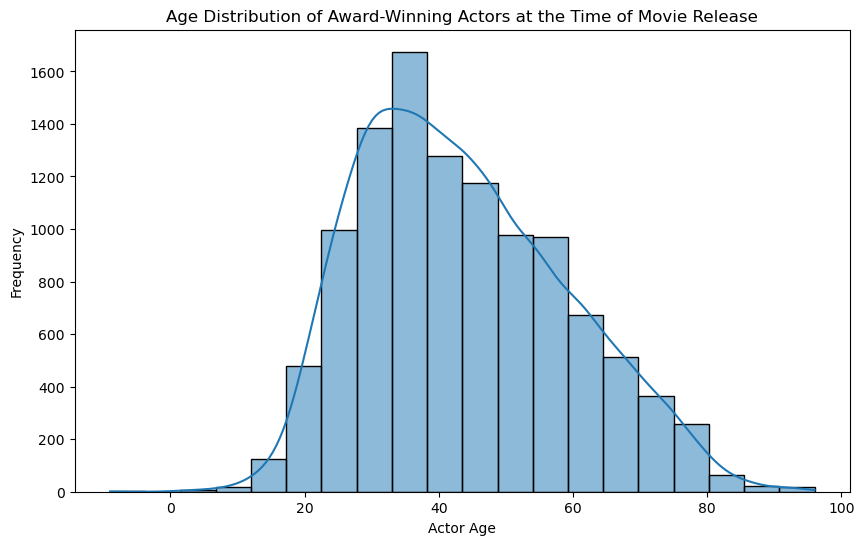

In [ ]:
# Filtering the characters DataFrame to include only award-winning actors
filtered_characters = character[character['Actor name'].isin(winning_actors_info['actor'])].copy()

# Ensure 'filtered_characters' is a proper copy to avoid SettingWithCopyWarning
filtered_characters.dropna(subset=['Actor age at movie release'], inplace=True)

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_characters['Actor age at movie release'], bins=20, kde=True)
plt.title('Age Distribution of Award-Winning Actors at the Time of Movie Release')
plt.xlabel('Actor Age')
plt.ylabel('Frequency')
plt.show()

By plotting this age distribution, we can see that most winning actors are middle-age with 30-40 years old.

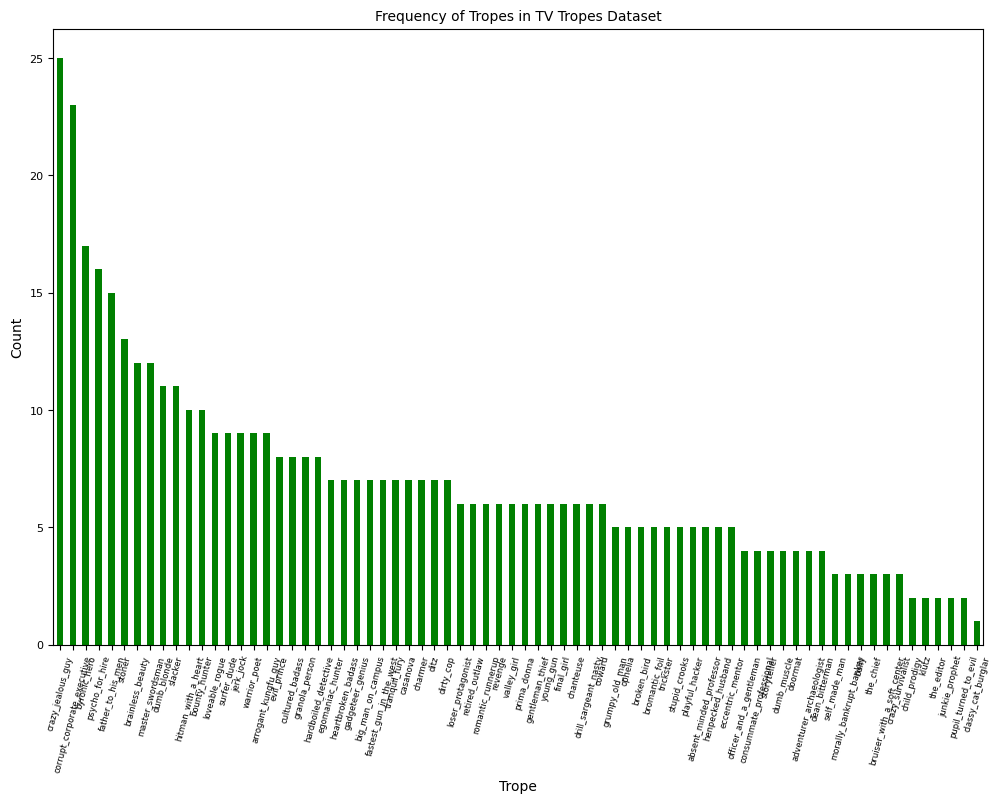

In [8]:
trope_counts = tvtropes['Trope'].value_counts()
plt.figure(figsize=(12, 8))
trope_counts.plot(kind='bar', color='green')
plt.xlabel('Trope', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Frequency of Tropes in TV Tropes Dataset', fontsize=10)
plt.xticks(rotation=75, fontsize=6)
plt.yticks(fontsize=8)
plt.show()

Here is the bar plot of most common genres in award-winning films.

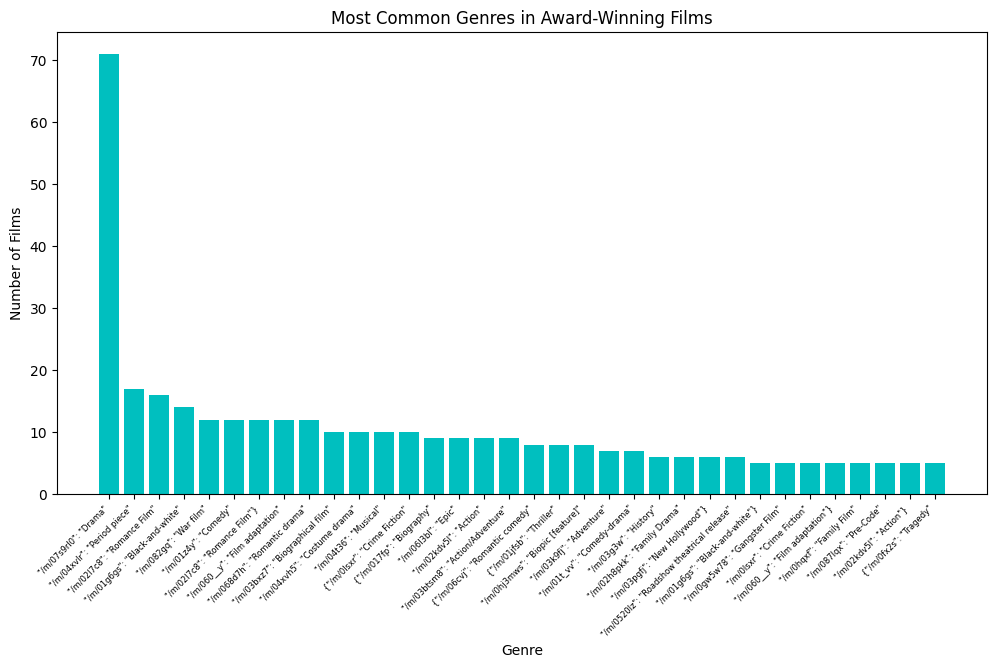

In [9]:
from collections import Counter 

oscar_films_ids = oscar_winning_films['Page ID']
oscar_films = movie[movie['Wikipedia movie ID'].isin(oscar_winning_films['Page ID'])]

# Flatten the list of genres and count occurrences
all_genres = [genre for sublist in oscar_films['Movie genres'].str.split(', ') for genre in sublist]
genre_counts = Counter(all_genres)

# Convert the counts to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

# Filter genres with at least 20 movies
genre_counts_df = genre_counts_df[genre_counts_df['Count'] >= 5]

# Plot the genre counts as a bar chart
plt.figure(figsize=(12, 6))
genre_counts_df.sort_values(by='Count', ascending=False, inplace=True)
plt.bar(genre_counts_df['Genre'], genre_counts_df['Count'], color='c')

plt.xticks(rotation=45, ha='right', fontsize=6)
plt.title('Most Common Genres in Award-Winning Films')
plt.ylabel('Number of Films')
plt.xlabel('Genre')
plt.show()

We can see that we have a lot more drama movies than other genre of movies, we have then to balance the data.

Here is the distribution of review score, primal for our comparison with reviews.

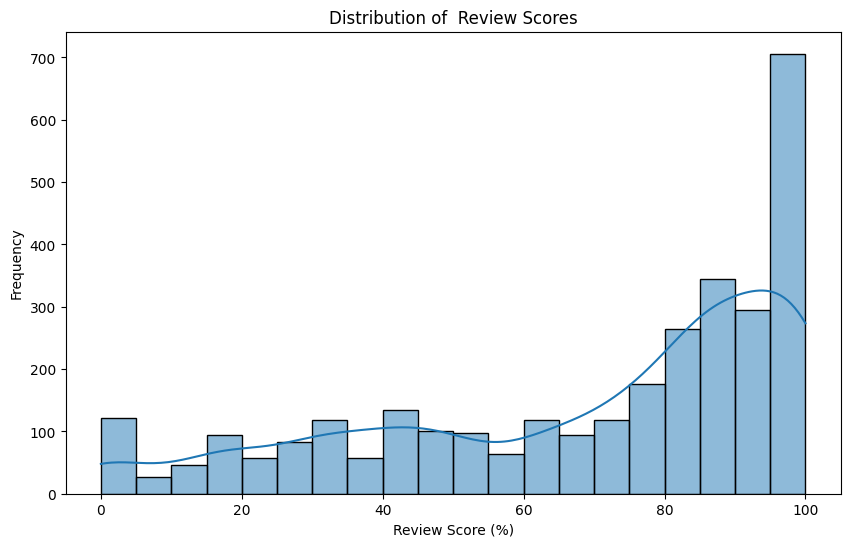

In [10]:
# Extract the first review score from the reviewScores column

# Drop rows with missing review scores
review_scores = extended_films['reviewScores'].dropna().apply(lambda x: [score for score in eval(x) if score != ['']]).dropna()
review_scores = review_scores.apply(lambda x: x[0] if len(x) > 0 else None).dropna()

# Convert the review scores to numeric values, ignoring errors
review_scores = pd.to_numeric(review_scores.str.replace('%', ''), errors='coerce').dropna()

# Plot the distribution of review scores
plt.figure(figsize=(10, 6))
sns.histplot(review_scores, bins=20, kde=True)
plt.title('Distribution of  Review Scores')
plt.xlabel('Review Score (%)')
plt.ylabel('Frequency')
plt.show()

The review scores are clearly going towards the 100%, but this can be because we are using the dataset of award-winning films.

Here is the sentiment compound distribution of plot summaries.

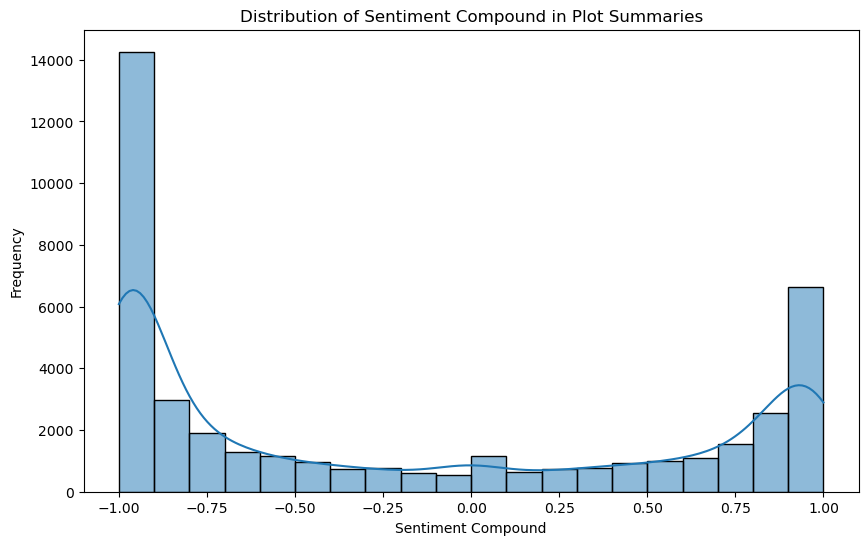

In [ ]:
# Plot the distribution of sentiment compound
plt.figure(figsize=(10, 6))
sns.histplot(plot_summaries['sentiment_compound'], bins=20, kde=True)
plt.title('Distribution of Sentiment Compound in Plot Summaries')
plt.xlabel('Sentiment Compound')
plt.ylabel('Frequency')
plt.show()

Here, using the CMU dataset, we apply some sentiment analysis from the NLTK corpus. Hence we can see here that most of plot summaries are more negative (-1) than positive (+1).

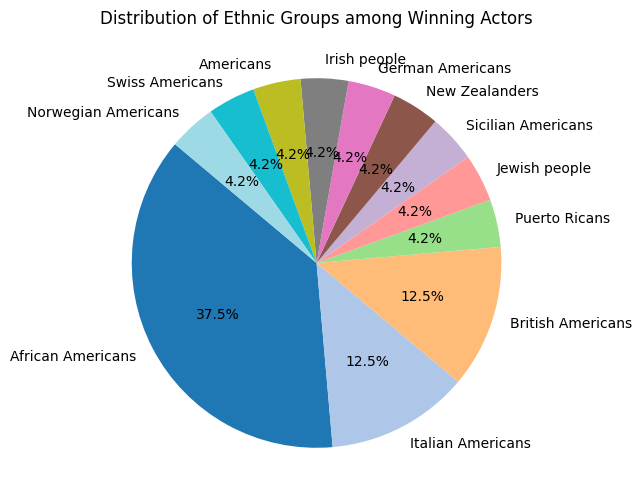

In [12]:
# Drop rows with missing ethnicGroupLabel
ethnic_group_counts = winning_actors_info['ethnicGroupLabel'].dropna().value_counts()

# Plotting the pie chart
plt.figure(figsize=(10, 6))
ethnic_group_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, cmap='tab20')
plt.title('Distribution of Ethnic Groups among Winning Actors')
plt.ylabel('')  # Hide the y-label
plt.show()

By using the winning actors dataset, we can see the ethnicity distribution of actors. Hence, we can see that ther is a strong proportion of African Americans.  

ALICE AND BOB MAD LAB MACHINE LEARNING 

In [141]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC  # SVM classifier with RBF kernel
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.compose import make_column_transformer


# Drop rows with NaN in the 'categories' column
ml_analysis = film_full.dropna(subset=['categories'])

ml_analysis['oscar'] = film_full['nbOscarReceived'] >=1
ml_analysis= ml_analysis[['oscar', 'title_length', 'categories', 'box_office', 'runtime']]
# Clean the 'categories' column
ml_analysis['categories'] = (
    ml_analysis['categories']
    .str.strip('[]')  # Remove square brackets
    .str.replace("'", '')  # Remove single quotes
    .str.replace('"', '')  # Remove double quotes
    .str.strip()  # Remove leading and trailing spaces
)

#Preprocess the data to have clean categories
ml_analysis['categories'] = ml_analysis['categories'].apply(lambda s: [x.strip() for x in s.split(',')] if isinstance(s, str) else [])
ml_analysis['categories'] = ml_analysis['categories'].apply(lambda s: list(set(filter(None, s))))
ml_analysis['categories'] = ml_analysis['categories'].apply(lambda s: [x.lower().capitalize() for x in s])


ml_analysis= ml_analysis.explode('categories')
ml_analysis = ml_analysis.dropna(subset=['oscar', 'title_length', 'categories', 'box_office', 'runtime'])

# Features and target
y = ml_analysis['oscar']  
X = ml_analysis[['title_length', 'categories', 'box_office', 'runtime']]

# Preprocess categorical and numerical features before SMOTE
pre_smote_preprocessor = make_column_transformer(
    (StandardScaler(with_mean=False), ['title_length', 'box_office', 'runtime']),  # Scale numerical columns
    (OneHotEncoder(drop='first', sparse_output=True), ['categories'])  # Encode categorical column
)

# Apply preprocessing before SMOTE
X_preprocessed = pre_smote_preprocessor.fit_transform(X)

# Resample data using SMOTE since with have unbalanced data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

# Define preprocessing for the pipeline 
pipeline_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), slice(0, X_resampled.shape[1]))  # Scale all features post-SMOTE
    ]
)

# Create the SVM pipeline with RBF kernel
svm_pipeline = Pipeline(steps=[
    ('preprocessor', pipeline_preprocessor),
    ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42))  # Enable probability
])

# Perform hyperparameter tuning, by convenience we already put the best paremeters we obtained with it
param_grid = {
    'svm__C': [10],
    'svm__gamma': [24]
}
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_

# Cross-validation with the best model
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='recall')
print("Cross-validation accuracy scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))

# Fit the model and generate predictions
best_model.fit(X_resampled, y_resampled)
y_pred = best_model.predict(pre_smote_preprocessor.transform(X))

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['svm'].classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (RBF Kernel)')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y, y_pred))


Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

# Actors analysis

In [194]:
from src.scripts.actors_analysis import data_cleaning, deriving_actors_dataset_preprocessing, get_genre_count, get_pie_genre_counts, get_movies_and_first_oscar_date, evolution_imdb_scores, show_imdb_scores, get_actor_genre_distribution, bubble_graph
oscar_actors_info = load_dataframe_from_csv('oscar_actors_info.csv')
oscar_actress_info = load_dataframe_from_csv('oscar_actress_info.csv')
winning_actors_info = load_dataframe_from_csv('winning_actors_information.csv')
movie_cmu = load_dataframe_from_csv('movie_cmu.csv')
character = load_dataframe_from_csv('character.csv')
plot_summaries = load_dataframe_from_csv('plot_summaries.csv')
extended_films = load_dataframe_from_csv('film_2015_2024.csv')
academy_award_winning_films = load_dataframe_from_csv('acedemy_award_winning_films')
winning_actors_info = load_dataframe_from_csv('winning_actors_information.csv')
film_full =  load_dataframe_from_csv('film_full_2.csv')
imdb_ratings = load_dataframe_from_csv('imdb_ratings.csv')

In [195]:
extended_films, winning_actors_info, imdb_ratings, film_full = data_cleaning(extended_films, winning_actors_info, imdb_ratings, film_full)

In [196]:
revenue_by_year_corrected, oscar_act_info, oscar_act_movies, oscar_act_movies_all = deriving_actors_dataset_preprocessing(oscar_winning_actors, oscar_winning_actresses, movie_cmu, extended_films, film_full, winning_actors_info, character)

In [197]:
# Create a line chart
fig = px.line(
    revenue_by_year_corrected,
    x='Year',
    y='Movie box office revenue',
    title='Evolution of Movie Box Office Revenue Over the Years',
    labels={'Year': 'Year', 'Movie box office revenue': 'Box Office Revenue ($)'},
    line_shape='spline'
)

# Update layout for better readability
fig.update_layout(
    xaxis=dict(title='Year'),
    yaxis=dict(title='Total Box Office Revenue ($)', tickformat='$,.0f'),
    width=1400, 
    height=600  
)

fig.show()

In [198]:
if 'Actor age at movie release' in oscar_act_info.columns:
    # Count occurrences of each age
    age_distribution = oscar_act_info['Actor age at movie release'].value_counts().reset_index()
    age_distribution.columns = ['Actor age at movie release', 'count']
    
    # Sort by age for better visualization
    age_distribution = age_distribution.sort_values(by='Actor age at movie release')

    # Create the bar plot
    fig = px.bar(age_distribution, x='Actor age at movie release', y='count', title='Age Distribution', labels={'age': 'Age', 'count': 'Count'})
    fig.show()
else:
    print("The column 'age' does not exist in the provided file.")

In [199]:
# Prepare data for men, women, and both
# Assuming `age_distribution` contains combined data, and separate dataframes exist for men and women
men = oscar_actors_info['Actor age at movie release'].value_counts().reset_index()
women = oscar_actress_info['Actor age at movie release'].value_counts().reset_index()

# Rename columns for consistency
men.columns = ['Age', 'Actors']
women.columns = ['Age', 'Actresses']

# Merge all into a single dataframe for plotting
merged = men.merge(women, on='Age', how='outer').fillna(0)

# Melt the data for easier plotting with Plotly
melted = merged.melt(id_vars='Age', value_vars=['Actors', 'Actresses'], 
                     var_name='Group', value_name='Count')

# Plot grouped bar chart
fig = px.bar(melted, x='Age', y='Count', color='Group', barmode='group',
             labels={'Age': 'Age', 'Count': 'Count', 'Group': 'Group'},
             title='Age Distribution')
fig.show()

In [200]:
# Print all unique values in the 'Actor ethnicity' column
unique_ethnicities = oscar_act_info['Actor ethnicity'].unique()

# Display the unique values
print(unique_ethnicities)

[nan 'Jewish people' 'Irish Americans' 'Scottish Americans'
 'Puerto Ricans' 'Dutch Americans' 'Swiss' 'African Americans'
 'Scotch-Irish Americans' 'White people' 'White Americans'
 'Italian Americans' 'Slovak Americans' 'Indians' 'English people'
 'Irish migration to Great Britain' 'Portuguese Americans'
 'German Americans' 'Italians' 'Māori' 'Hungarian Americans' 'Akan people'
 'British' 'Canadian Americans' 'British Americans' 'Swedish Americans'
 'Irish people' 'American Jews' 'White British' 'Germans'
 'Czech Americans' 'Armenians' 'English Americans' 'Spanish Americans'
 'White Africans of European ancestry' 'French' 'Israeli Americans']


In [201]:
country_counts = oscar_act_info['countryOfCitizenshipLabel'].value_counts()
country_counts = country_counts.reset_index()
country_counts.columns = ['Country', 'Count']

fig = px.choropleth(country_counts, 
                    locations="Country", 
                    locationmode='country names', 
                    color="Count", 
                    hover_name="Country", 
                    title="Heatmap of Oscar Winning Actors by Country")
fig.update_geos(showcountries=True)
fig.show()

In [202]:
country_counts = oscar_act_info['countryOfCitizenshipLabel'].value_counts()
country_counts = country_counts.reset_index()
country_counts.columns = ['Country', 'Count']

fig = px.choropleth(country_counts, 
                    locations="Country", 
                    locationmode='country names', 
                    color="Count", 
                    hover_name="Country", 
                    title="Heatmap of Oscar Winning Actors by Country")
fig.update_geos(showcountries=True, visible=True)
fig.update_geos(lonaxis_range=[-10, 40], lataxis_range=[35, 70])
fig.show()

In [203]:
print('Average Capital Cost of the movies starring the actresses:', oscar_act_movies['capitalCost'].median()) 
print('Average Box Office revenue of the movies starring the actresses:', oscar_act_movies['Movie box office revenue'].median())
print('Average Benefits of the movies starring the actresses:', (oscar_act_movies['Movie box office revenue'] - oscar_act_movies['capitalCost']).median())


Average Capital Cost of the movies starring the actresses: 25000000.0
Average Box Office revenue of the movies starring the actresses: 41461428.0
Average Benefits of the movies starring the actresses: 96792237.0


In [204]:
filtered_genre_counts = get_genre_count(oscar_act_info, oscar_act_movies_all)
# Create the improved bar chart with log scale
fig = px.bar(
    filtered_genre_counts.sort_values('Count', ascending=False),
    x='Movie_genres_split',
    y='Count',
    color='Best Actor Reward',
    title='Top 15 Movie Genres (Oscar-Winning vs Non-Oscar-Winning)',
    labels={'Movie_genres_split': 'Movie Genre', 'Count': 'Number of Movies'},
    barmode='group',
    log_y=True  # Set y-axis to log scale
)

# Update layout for better readability
fig.update_layout(
    xaxis=dict(tickangle=45, title='Movie Genre'),
    yaxis=dict(title='Number of Movies (Log Scale)'),
    width=1000,  # Increase figure width
    height=500   # Adjust height
)

# Uncomment this to visualize
fig.show()

In [205]:
box_office_data = oscar_act_movies_all[['Movie box office revenue', 'Best Actor Reward']].dropna()

# Create a box plot to show the distribution of box office revenue
fig = px.box(
    box_office_data,
    x='Best Actor Reward',
    y='Movie box office revenue',
    title='Box Office Revenue Distribution (Oscar-Winning vs Non-Oscar-Winning)',
    labels={'Best Actor Reward': 'Movie Type', 'Movie box office revenue': 'Box Office Revenue ($)'},
    color='Best Actor Reward'
)

# Update layout for better readability⁄
fig.update_layout(
    xaxis=dict(title='Best Actor Reward'),
    yaxis=dict(title='Box Office Revenue ($)', tickformat='$,.0f'),
    width=800,  # Adjust figure width
    height=600  # Adjust figure height
)

# Uncomment this to visualize
fig.show()

In [206]:
scatter_data = oscar_act_info[['Actor age at movie release', 'Movie box office revenue']].dropna()


fig = px.scatter(
    scatter_data,
    x='Actor age at movie release',
    y='Movie box office revenue',
    title='Actors Age vs. Movie Box Office Revenue (Oscar-Winning Movies)',
    labels={
        'Actor age at movie release': 'Age at Movie Release',
        'Movie box office revenue': 'Box Office Revenue ($)'
    },
    size='Movie box office revenue',
    hover_data=['Actor age at movie release'],
    color_discrete_sequence=['purple']
)


fig.update_layout(
    xaxis=dict(title='Age at Movie Release'),
    yaxis=dict(title='Box Office Revenue ($)', tickformat='$,.0f'),
    width=800,  
    height=600  
)

fig.show()

In [207]:
genre_counts = get_pie_genre_counts(oscar_act_movies_all)

# Plot the top 10 genres
fig = px.pie(
    genre_counts.head(10), 
    values='Count',
    title='Top 10 Genres in Best Actor/Actress Academy Award Movies',
    labels={'Genre': 'Movie Genre', 'Count': 'Number of Movies'},
    names='Genre',
    color='Genre'
)

# Update layout for better readability
fig.update_layout(
    xaxis=dict(title='Movie Genre', tickangle=45),
    yaxis=dict(title='Number of Movies'),
    width=800,
    height=600 
)

fig.show()

In [208]:
oscar_movies_filtered = oscar_act_movies_all.dropna(subset=['Movie release date'])
print(oscar_act_movies_all.columns)
movies_before_first_oscar = oscar_movies_filtered.groupby('Actor name').apply(get_movies_and_first_oscar_date).reset_index()

fig = px.bar(
    movies_before_first_oscar.sort_values('Movies Before First Oscar', ascending=False),
    x='Actor name',
    y='Movies Before First Oscar',
    title='Number of Movies Before First Oscar per Actor',
    labels={'Actor name': 'Actor', 'Movies Before First Oscar': 'Movies Before First Oscar'},
    hover_data='First Oscar Date',
    text='Movies Before First Oscar',
    color='Movies Before First Oscar',
    color_continuous_scale='Reds'
    
)

# Update layout for better readability
fig.update_layout(
    xaxis=dict(title='Actor', tickangle=45),
    yaxis=dict(title='Number of Movies'),
    width=2000,  # Adjust figure width
    height=700  # Adjust figure height
)

# Uncomment this line to display the graph
fig.show()

Index(['Wikipedia movie ID', 'Character name', 'Actor date of birth',
       ' Actor gender', 'Actor height)', 'Actor ethnicity', 'Actor name',
       'Actor age at movie release', 'Freebase character',
       'Freebase character ID', 'Freebase actor ID', 'Freebase movie ID',
       'Movie name', 'Movie release date', 'Movie box office revenue',
       'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres',
       'Best Actor Reward'],
      dtype='object')


In [209]:
rating_evolution = evolution_imdb_scores(imdb_ratings, oscar_act_movies_all)

In [210]:
show_imdb_scores(rating_evolution)

In [211]:
genre_counts = get_actor_genre_distribution(oscar_act_movies_all)

# Create a grouped bar chart
fig = px.bar(genre_counts, 
                x='Actor name', 
                y='count',
                color='Movie genres',
                title='Major Film Genres by Oscar-Winning Actor',
                labels={'count': 'Number of Movies', 'Actor name': 'Actor'},
                height=800)

# Update layout for better readability
fig.update_layout(
        xaxis={'categoryorder':'total descending'},
        showlegend=True,
        legend_title='Genre',
        barmode='stack',
        xaxis_tickangle=-45
    )

fig.show()


In [214]:
rating_box_office = bubble_graph(winning_actors_info, oscar_winning_actors, oscar_winning_actresses, film_full, character, imdb_ratings, oscar_winning_films)

In [215]:
# Create a bubble chart using Plotly Express
fig = px.scatter(
    rating_box_office,
    x='Movie release date',
    y='imdb_score',
    size='Movie box office revenue',
    hover_name='Movie name',  # Adjust column name if necessary
    title="Bubble Graph: IMDb Score vs. Movie Release Date (Bubble Size: Box Office Revenue)",
    color='nbOscarNominated',
    labels={
        'Movie release date': 'Release Date',
        'imdb_score': 'IMDb Score',
        'Movie box office revenue': 'Box Office Revenue'
    },
    category_orders={'nbOscarNominated': sorted(rating_box_office['nbOscarNominated'].unique())}  # Sort legend
)

# Show the plot
fig.show()